<a href="https://colab.research.google.com/github/Elsiekiprop/Sales-Prediction--Time-Series-Models/blob/gikonyo/Sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Store Sales - Time Series Forecasting.
## Overview
This project aims to predict sales of various products at Favorita stores in Ecuador.
# **Business Understanding**

- The goal of the project is to develop a time series model that accurately predicts unit sales at different locations for Favorita stores.

Questions to be Asked:

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year?
3. Did the earthquake impact sales?
4. Are certain groups of stores selling more products? (Cluster, city, state, type)
5. Are sales affected by promotions, oil prices and holidays?
6. What analysis can we get from the date and its extractable features?
7. What is the difference between RMSLE, RMSE, and MSE (or why is the MAE greater than all of them?)

**Data Understanding.**

Seven data sets will be used in this project. The data sets are as follows:

**Holidays.csv**
- Days that are celebrated are marked with '**Transfer**'.
- Days that are added to a holiday are marked with '**Bridge**' (extending a holiday)
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. *Supermarket sales could be affected by this.*
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

**Train.csv**
This data set includes data on:
- date: day the sale occured
- id: the sales id
- store_nbr: the store at which the sale occured
- sales: total sales for a given product family at a given store at a given date.
- onpromotion: total  number of items promoted at a given store at a given date.

The  **test.csv** file contains data similar to the training data. The data contains sales information collected 15 days after the train data.

- The training data, comprising time series of features **store_nbr**, **family**, and **onpromotion** as well as the target sales.
- **store_nbr** identifies the store at which the products are sold.
- **family** identifies the type of product sold.
- **sales** gives the total sales for a product family at a particular store at a given date.Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

**Oil.csv**

This file contains details on oil prices since Ecuador's economy heavily depends on Oil

- Daily oil price. Includes values during both the train and test data timeframes.

(Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)


(*How does oil prices affect store sales?*)

**Stores.csv**

This file includes information on store location:
- city: the city a state is located
- state: the state a city is located
- cluster: a group of similar stores
- type: the type of store

**Transactions.csv**




In [46]:
!pip install dataprep
!pip install seaborn
!pip install pandas-datareader

# Importing necessary libraries.



In [47]:
'''
  if we were reading from the net, we would have to use this approach
'''
# import datetime
# import pandas_datareader.data as web
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

'\n  if we were reading from the net, we would have to use this approach\n'

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# for plotting time series
import plotly.express as px
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans

#imports for cleaning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score

#imports for EDA
from dataprep.eda import create_report

# imports for stationary tests
from statsmodels.tsa.stattools import adfuller

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Common Functions

In [50]:
def DropColumns(col_names, df):
    # input: list of column names and a dataframe
    # output: same dataframe with columns dropped
    df = df.drop(col_names, axis=1)
    return df

def iqr_outliers(df,ft):
  """
  input: dataframe and features
  description: will remove outliers based on interquartile range
  output: is a list of rows to be removed
  """
  q1=df[ft].quantile(0.05)
  q2=df[ft].quantile(0.95)
  iqr = q2-q1
  lower = q1 - 1.5 * iqr
  upper = q2 + 1.5 * iqr
  ls = df.index[ (df[ft]<lower) | (df[ft]>upper) ]
  return ls

def remove_(df,ls):
  """
  input:dataframe, list of rows
  description: will remove the rows
  output: dataframe
  """
  ls = sorted(set(ls))
  df = df.drop(ls)
  return df

def fill_null(df):
  """
    input: dataframe
    description: the fxn will fill missing integer values with 0 and missing categorical values with the mode in their respective columns
    output: dataframe with filled values
  """
  for col in df:
    if df[col].dtype in ("int64", "float64"):
      df[col] = df[col].fillna(df[col].mean(numeric_only=True))
    elif df[col].dtype == "object":
      df[col] = df[col].fillna(df[col].mode()[0])
  print("Finished removing null values")
  return df

def iqr_outliers(df,ft):
  """
  input: dataframe and features
  description: will remove outliers based on interquartile range
  output: is a list of rows to be removed
  """
  q1=df[ft].quantile(0.05)
  q2=df[ft].quantile(0.95)
  iqr = q2-q1
  lower = q1 - 1.5 * iqr
  upper = q2 + 1.5 * iqr
  ls = df.index[ (df[ft]<lower) | (df[ft]>upper) ]
  return ls

In [51]:
def standard_scaler(df):
  '''
  input: dataframe
  description: will standardize data
  output: a standardized dataframe
  '''
  scaler = StandardScaler()
  scaled_df = scaler.fit_transform(df)

  return scaled_df

def elbow_meth(df, cluster_num):
  SSE = {}
  for cluster_num in range(1, 10):
    k_means = KMeans(n_clusters=cluster_num, max_iter=1000).fit(df)
    df['clusters'] = k_means.labels_
    SSE[cluster_num] = k_means.inertia_
    # AvS = silhouette_score(df, df['clusters'], metric='euclidean')
    # print("For n_clusters={}, The Solhouette Coefficient is {}".format(cluster_num, AvS))

  plt.figure()
  plt.plot(list(SSE.keys()), list(SSE.values()))
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")
  plt.show()

def one_hot_encode(df,selected_columns):
  """
  input: dataframe
  description: dataframe will be label encoded and then onehot encoded
  output: onehot encoded dataframe
  """
  one_hot_enc_df=pd.get_dummies(df,columns=selected_columns)

  return one_hot_enc_df

def label_encode(df, selected_cols):
  """
  input: dataframe
  description: dataframe will be label encoded
  output: onehot encoded dataframe
  """
  label_encoder = LabelEncoder()

  for k in selected_cols:
    df[k] = label_encoder.fit_transform(df[k])

  return df

def dickie_fuller_test(df):
  result = adfuller(df)

  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')

  for key, value in result[4].items():
    print('\t%s: %.3f' % (key,value))

  if result[0] < result[4]["5%"]:
    print("Reject Ho - Time Series is Stationary!")
  else:
    print("Reject Ho - Time Series is not Stationary!")

# Data Access and Collection

In [52]:
path_var = '/content/drive/MyDrive/projects/Store-Sales-Forecast/store-sales-time-series-forecasting'

In [53]:
#Reading data
train_df=pd.read_csv(path_var + "/train.csv")
test_df=pd.read_csv(path_var + "/test.csv")
oil_df=pd.read_csv(path_var + "/oil.csv")
sample_submission_df=pd.read_csv(path_var + "/sample_submission.csv")
stores_df=pd.read_csv(path_var + "/stores.csv")
transactions_df=pd.read_csv(path_var + "/transactions.csv")
holidays_events_df=pd.read_csv(path_var + "/holidays_events.csv")

# Data Cleaning





## Combine Datasets

In [54]:
'''
  Train and Transaction have store number in common.
  So we can link store transactions with sales figures
'''
merge1 = pd.merge(train_df, transactions_df, on=['date', 'store_nbr'])
# merge holiday data to previous merged data on date column
merg2 = pd.merge(merge1, holidays_events_df, on='date')

In [55]:
# merge oil data to previous merged data on date column
merg3 = pd.merge(merg2, oil_df, on='date')

In [56]:
# Merge Store data to previous merged data on store_nbr column
merg4 = pd.merge(merg3, stores_df, on='store_nbr')

In [57]:
len(merg4)

322047

In [58]:
merg4.index = pd.to_datetime(merg4['date'], format='%Y-%m-%d')
'''
also you can use
merg4.set_index("date", inplace=True)
'''

'\nalso you can use\nmerg4.set_index("date", inplace=True)\n'

In [85]:
merg4

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
date,,,,,,,,,,,,,,,,,
2013-01-01,561,2013-01-01,25,AUTOMOTIVE,0.000,0,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Salinas,Santa Elena,D,1
2013-01-01,562,2013-01-01,25,BABY CARE,0.000,0,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Salinas,Santa Elena,D,1
2013-01-01,563,2013-01-01,25,BEAUTY,2.000,0,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Salinas,Santa Elena,D,1
2013-01-01,564,2013-01-01,25,BEVERAGES,810.000,0,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Salinas,Santa Elena,D,1
2013-01-01,565,2013-01-01,25,BOOKS,0.000,0,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Salinas,Santa Elena,D,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,3000685,2017-08-15,52,POULTRY,397.340,0,2255,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Manta,Manabi,A,11
2017-08-15,3000686,2017-08-15,52,PREPARED FOODS,104.418,0,2255,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Manta,Manabi,A,11
2017-08-15,3000687,2017-08-15,52,PRODUCE,3803.368,8,2255,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Manta,Manabi,A,11


Format visulization using Seaborn

In [60]:
sns.set()

sales and locations

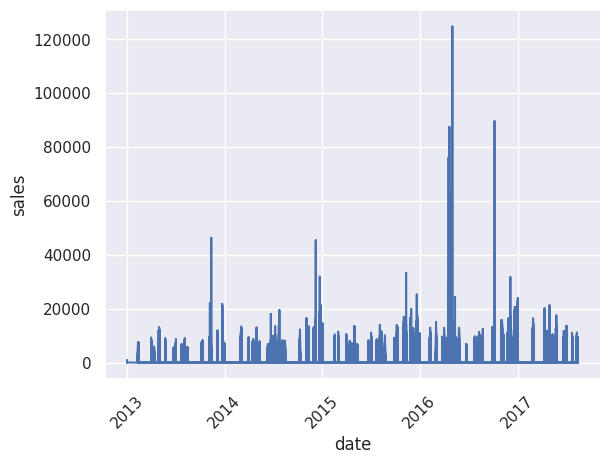

In [84]:
plt.ylabel('sales')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.plot(merg4.index, merg4['sales'])

# EDA

## Plot ACF / PACF charts
- *ACF* - Autocorrelation Function
- *PACF* - Partial Autocorrelation Function

The goal here is for a PACF plot to answer: Can the observed time series be modeled with an Autoregressive Model (AR)

**Autoregressive** means that the model will use past values to predict future ones. Specifically, predicted values are a weighted linear combination of past values. This type of regression method is similar to linear regression, with the difference being that the feature inputs here are historical values.

**Autoregression** models market participant behavior like buying and selling BTC. The white noise models shock events like wars, recessions and political events.

**Moving average** refers to the predictions being represented by a weighted, linear combination of white noise terms, where white noise is a random signal. The idea here is that ARMA uses a combination of past values and white noise in order to predict future values.

*   Plot ACF charts
*   Plot PACF charts
*   Find optimal parameters





## Check for ACF and PACF

ACF - Autocorrelation Function
PACF - Partial Autocorrelation Function

# Model Building and Training
Proposed models:
*   Prophet
*   Arma
*   ARIMA
*   SARIMA







## ARMA

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [28]:
y = merg4['sales']

In [29]:
ARMAModel = SARIMAX(y, order = (1,0,1))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [42]:
# fit model
ARMAModel = ARMAModel.fit()

AttributeError: ignored

Generate Predictions

In [34]:
y_pred = ARMAModel.get_forecast(len(test_df.index))
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df['Predictions'] = ARMAModel.predict(start=y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test_df.index
y_pred_out = y_pred_df["Predictions"]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


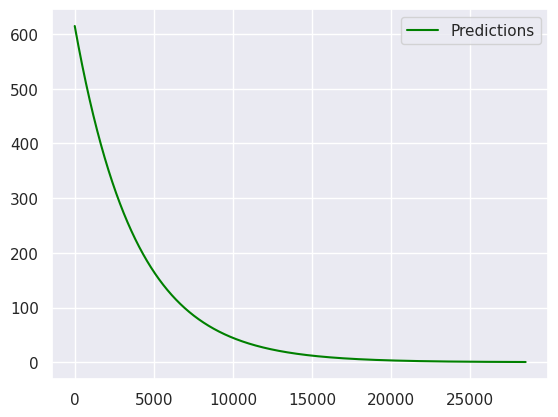

In [35]:
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

# Model Evaluation

Check for accuracy of models

# Deploy Model



*   Making predictions
*   List item



Reference:
- [Business Understanding Documentation](https://colab.research.google.com/drive/15PBqTZELcx73TdXUpsN7TVHOp-x6R7EU#scrollTo=j8-Bzga1LWOn)

- [Time Series Prediction](https://www.datacamp.com/tutorial/tutorial-time-series-forecasting)
- [Steps in Time Series forcasting](https://towardsdatascience.com/5-simples-steps-to-build-your-time-series-forecasting-model-62356336bc35)
- [A Gentle Introduction to Autocorrelation and Partial Autocorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)
- [A Guide to Time Series Forecasting in Python](https://builtin.com/data-science/time-series-forecasting-python)
- [ACF, PACF](https://itsudit.medium.com/deciphering-acf-and-pacf-plots-a-guide-to-time-series-forecasting-3323948935fb)

- [Unsupervised Credit Score](https://colab.research.google.com/drive/15PBqTZELcx73TdXUpsN7TVHOp-x6R7EU#scrollTo=j8-Bzga1LWOn)

- [Removing skewness](https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725)
- [Machine Learning Mastery - Scaling](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/)
- [Cleaning Financial Times Data](https://towardsdatascience.com/cleaning-financial-time-series-data-with-python-f30a3ed580b7)

- [Cleaning Categorical Data](https://www.kdnuggets.com/2023/04/exploring-data-cleaning-techniques-python.html)
